In [63]:
import numpy as np
import glob
import zipfile
import re
from datetime import datetime
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
plt.rcParams['axes.linewidth'] = 2.0
font = {'family' : 'DejaVu Sans',
       'weight' : 'normal',
       'size' : 16.0}
plt.rc('font',**font)

In [2]:
#Utility functions to upload and prepare data:
def get_images(file_name):
    
    '''Get images of the molecular cloud from zipped files. Takes in the file name and
       outputs all images contained within the file as a numpy array.'''
    
    archive = zipfile.ZipFile(file_name + '.zip')
    archive_n = archive.namelist()
    im_names = [im for im in archive_n if ('Image' in im)]
    naturals = lambda names : [i[i.find("_")+1:i.find(".")] for i in names]
    im_names = sorted(im_names, key=naturals)
    images = np.array([io.imread(archive.open(name)) for name in im_names])
    archive.close()
    return images

def get_mol_n(images, bg, eta):
    bg_count = bg.mean(axis=1).sum()
    return ((images.sum(axis=(1,2)) - bg_count) * eta).round(0)

def get_ToFs(file_name):
        
    '''Get time of flight profiles from zipped files. Takes in the file name and
       outputs all images contained within the file as a numpy array.'''
    
    archive = zipfile.ZipFile(file_name + '.zip')
    archive_n = archive.namelist()
    tof_names = [tof for tof in archive_n if ('Tof' in tof)]
    naturals = lambda date: datetime.strptime(date[4:-4], "%Y-%m-%d--%H-%M-%S-%f")
    tof_names = sorted(tof_names, key=naturals)
    tofs = np.array([pd.read_csv(archive.open(name)) for name in tof_names])[:, :, 0]
    archive.close()
    return tofs

def build_data_set(date, file_numbers, bg_number):
    
    '''Makes the complete data set. The features are the time of flight profiles and the target values are 
       the integrated images of molecular MOT's. Outputs a pair of numpy arrays. First one contains the time of flight
       profiles, the second contains the corresponding integrated MOT images.'''
    
    eta = 1e-2
    date = '24Nov21'
    bg_file = 'CaF' + date + '00_' + format(bg_number, '03')
    n_mols = np.array([])
    tofs = np.array([])
    for f in file_numbers:
        file_number = format(f, '03')
        file = 'CaF' + date + '00_' + file_number
        im = get_images(file)
        bg = get_images(bg_file)
        mol_n = get_mol_n(im, bg, eta)
        tof = get_ToFs(file)
        tof_bg = get_ToFs(bg_file)
        tof = tof - tof_bg.mean(axis=0)
        tof = (tof * 1e3).round(4)
        
        n_mols = np.append(n_mols, mol_n)
        tofs = np.vstack((tofs, tof)) if tofs.size else tof
        
    return tofs, n_mols   

# Using only the principal component

In [105]:
X, Y = build_data_set('24Nov21', [59, 60, 61, 63, 281], 62)
MOT_number = Y * 1e-4

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, MOT_number.reshape(-1, 1))

In [107]:
scaler = StandardScaler()
X_ss_train = scaler.fit_transform(X_train)

In [108]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_ss_train)

In [109]:
def mapper(x):
    if x <= 1.0:
        return 0
    elif x > 1.0 and x <= 1.5:
        return 1
    elif x > 1.5 and x <= 2.0:
        return 2
    elif x > 2.0:
        return 3

Text(0, 0.5, 'Principal component 2')

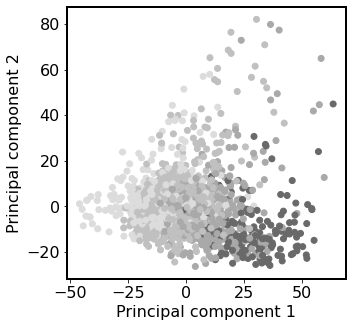

In [110]:
colors = {0:'gainsboro', 1:'silver', 2:'darkgrey', 3:'dimgrey'}
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], 
           c=pd.Series(y_train.flatten()).map(mapper).map(colors).tolist())
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

Text(0, 0.5, 'MOT number')

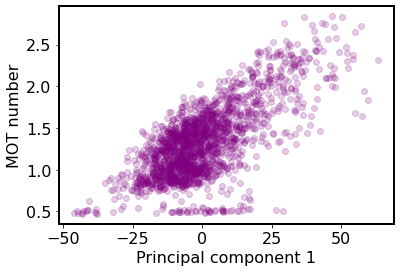

In [111]:
fig, ax = plt.subplots()
ax.scatter(principalComponents[:, 0], y_train.flatten(), color='purple', alpha=0.2)
ax.set_xlabel('Principal component 1')
ax.set_ylabel('MOT number')

In [113]:
reg_model = LinearRegression()
reg = reg_model.fit(principalComponents[:, 0].reshape(-1, 1), y_train.flatten().reshape(-1, 1))

X_ss_test = scaler.fit_transform(X_test)
X_ss_test = pca.transform(X_ss_test)[:, 0]
predictions_reg = reg.predict(X_ss_test.reshape(-1, 1))
mse_reg = mean_squared_error(y_test.reshape(-1, 1), predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.08836771300040587


Text(0, 0.5, 'Measured ($10^{4}$)')

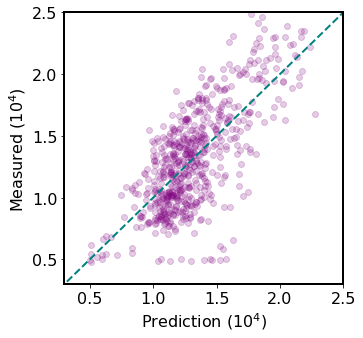

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')

# Using more principal components

(1.0, 10.0)

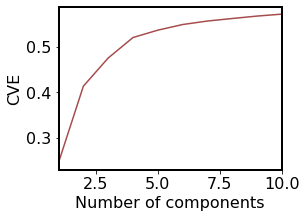

In [121]:
scaler = StandardScaler()
X_ss_train = scaler.fit_transform(X_train)

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_ss_train)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_), color='maroon', alpha=0.7)
ax.set_xlabel('Number of components')
ax.set_ylabel('CVE')
ax.set_xlim([1,10])

In [124]:
reg_model = LinearRegression()
reg = reg_model.fit(principalComponents[:, :5], y_train.flatten().reshape(-1, 1))

X_ss_test = scaler.fit_transform(X_test)
X_ss_test = pca.transform(X_ss_test)[:, :5]
predictions_reg = reg.predict(X_ss_test)
mse_reg = mean_squared_error(y_test.reshape(-1, 1), predictions_reg)
print('Test mean squared errror = ', mse_reg)

Test mean squared errror =  0.05564091144526285


Text(0, 0.5, 'Measured ($10^{4}$)')

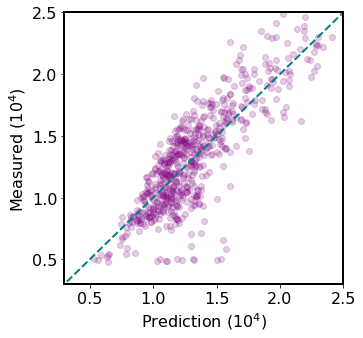

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(predictions_reg, y_test, color='purple', alpha=0.2)
ax.plot(np.arange(0.2,2.6,0.05), np.arange(0.2,2.6,0.05), color='teal', linestyle='--', linewidth=2.0)
ax.set_xlim([0.3,2.5])
ax.set_ylim([0.3,2.5])
ax.set_xlabel('Prediction ($10^{4}$)')
ax.set_ylabel('Measured ($10^{4}$)')